<a href="https://colab.research.google.com/github/ssamadjon3106/PyTorch-with-Deep-Learning/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sklearn
from sklearn.datasets import make_circles
n_samples=1000
X, y=make_circles(n_samples,
                  noise=0.03,
                  random_state=42)

In [7]:
len(X), len(y)

(1000, 1000)

In [8]:
X[:5]
y[:5]

array([1, 1, 1, 1, 0])

In [9]:
import pandas as pd
circles=pd.DataFrame({'X1': X[:, 0],
                     'X2': X[:, 1],
                      'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


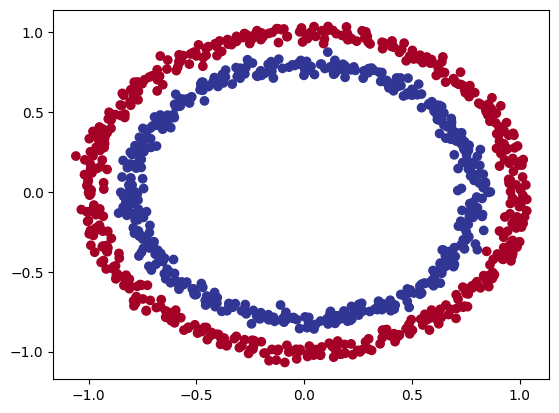

In [10]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [11]:
y.shape

(1000,)

In [12]:
type(X)

numpy.ndarray

In [13]:
import torch

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,
                                             y,
                                             test_size=0.2,
                                              random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Building model

In [16]:
import torch
from torch import nn

In [17]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #Create nn.Linear layers capable of handling shapes of data
    self.layer_1=nn.Linear(in_features=2, out_features=5)
    self.layer_1=nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_1(self.layer_1(x))

model_0=CircleModelV0()
model_0


CircleModelV0(
  (layer_1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
next(model_0.parameters()).to(device)

Parameter containing:
tensor([[ 0.2245, -0.4274,  0.3174, -0.2372, -0.2248]], requires_grad=True)

In [20]:
from torch import nn
model_0=nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2858, -0.3799],
                      [-0.0202,  0.5863],
                      [ 0.0430, -0.3642],
                      [ 0.5603, -0.4594],
                      [-0.1115, -0.6240]])),
             ('0.bias', tensor([-0.3382,  0.1183, -0.6122,  0.1718, -0.1225])),
             ('1.weight',
              tensor([[ 0.4282, -0.1055, -0.0849,  0.0915,  0.3418]])),
             ('1.bias', tensor([0.2318]))])

In [22]:
# Set up loss function and optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [23]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [24]:
model_0.eval()
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))[:5]
y_logits


tensor([[-0.2564],
        [-0.3286],
        [ 0.1474],
        [-0.3717],
        [ 0.4880]])

In [25]:
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4362],
        [0.4186],
        [0.5368],
        [0.4081],
        [0.6196]])

In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
from numpy import squeeze
# find predicted labels
y_preds=torch.round(y_pred_probs)

y_pred_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=1000
X_train, y_train, X_test, y_test=X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)).to(device)
  #Calculate loss/accuracy
  loss=loss_fn(y_logits, y_train)
  acc=accuracy_fn(y_true=y_train, y_pred=y_pred)
  #Optimizer to zero grad
  optimizer.zero_grad()
  loss.backward()
  optimizer.step() # gradient descent

  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits, y_test)
    test_acc=accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch %10==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}')

Epoch: 0 | Loss: 0.70795 | Acc: 50.38 | Test Loss: 0.69641 | Test_acc: 53.00
Epoch: 10 | Loss: 0.70748 | Acc: 50.38 | Test Loss: 0.69615 | Test_acc: 52.50
Epoch: 20 | Loss: 0.70703 | Acc: 50.38 | Test Loss: 0.69591 | Test_acc: 52.50
Epoch: 30 | Loss: 0.70660 | Acc: 50.25 | Test Loss: 0.69568 | Test_acc: 52.50
Epoch: 40 | Loss: 0.70618 | Acc: 50.38 | Test Loss: 0.69546 | Test_acc: 52.50
Epoch: 50 | Loss: 0.70578 | Acc: 50.38 | Test Loss: 0.69525 | Test_acc: 52.50
Epoch: 60 | Loss: 0.70540 | Acc: 50.12 | Test Loss: 0.69506 | Test_acc: 52.50
Epoch: 70 | Loss: 0.70502 | Acc: 50.12 | Test Loss: 0.69487 | Test_acc: 52.50
Epoch: 80 | Loss: 0.70467 | Acc: 50.12 | Test Loss: 0.69469 | Test_acc: 52.50
Epoch: 90 | Loss: 0.70432 | Acc: 50.12 | Test Loss: 0.69451 | Test_acc: 52.50
Epoch: 100 | Loss: 0.70398 | Acc: 50.12 | Test Loss: 0.69435 | Test_acc: 52.50
Epoch: 110 | Loss: 0.70366 | Acc: 50.25 | Test Loss: 0.69420 | Test_acc: 52.50
Epoch: 120 | Loss: 0.70335 | Acc: 50.25 | Test Loss: 0.69405 | 

In [29]:
import requests
from pathlib import Path
if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

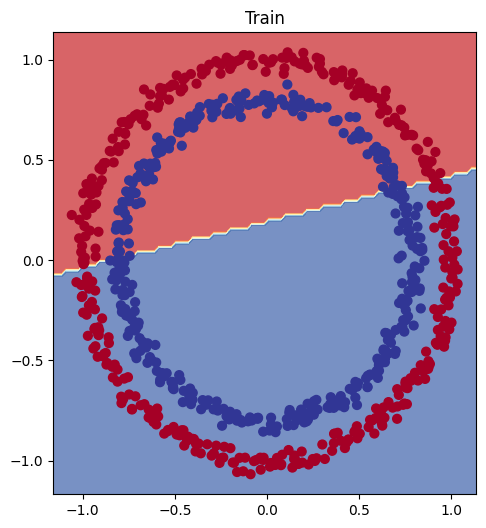

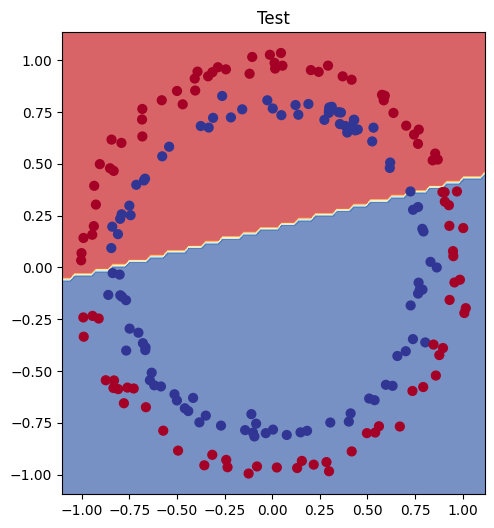

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

In [31]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.n_layers=nn.Sequential(
        nn.Linear(in_features=2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=1)
    )

  def forward(self, x):
    return self.n_layers(x)
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (n_layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [32]:
#create loss function
loss_fn=nn.BCEWithLogitsLoss()

#create optimizer
optimizer=torch.optim.Adam(params=model_1.parameters(), lr=0.01)


In [33]:
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100
X_train, y_train, X_test, y_test=X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  model_1.train()
  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits, y_train)
  acc=accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_1.eval()
  with torch.inference_mode():
    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits, y_test)
    test_acc=accuracy_fn(y_true=y_test, y_pred=test_pred)
  if epoch%10==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test: {acc:.2f} | Test Loss: {test_loss:.5f} |  Test acc: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69280 | Test: 57.12 | Test Loss: 0.69954 |  Test acc: 50.00
Epoch: 10 | Loss: 0.54980 | Test: 61.50 | Test Loss: 0.26342 |  Test acc: 97.00
Epoch: 20 | Loss: 0.03638 | Test: 99.75 | Test Loss: 0.05446 |  Test acc: 98.50
Epoch: 30 | Loss: 0.01683 | Test: 99.62 | Test Loss: 0.01574 |  Test acc: 99.00
Epoch: 40 | Loss: 0.00429 | Test: 99.88 | Test Loss: 0.02162 |  Test acc: 99.00
Epoch: 50 | Loss: 0.00036 | Test: 100.00 | Test Loss: 0.00103 |  Test acc: 100.00
Epoch: 60 | Loss: 0.00020 | Test: 100.00 | Test Loss: 0.00073 |  Test acc: 100.00
Epoch: 70 | Loss: 0.00012 | Test: 100.00 | Test Loss: 0.00077 |  Test acc: 100.00
Epoch: 80 | Loss: 0.00008 | Test: 100.00 | Test Loss: 0.00100 |  Test acc: 100.00
Epoch: 90 | Loss: 0.00006 | Test: 100.00 | Test Loss: 0.00061 |  Test acc: 100.00


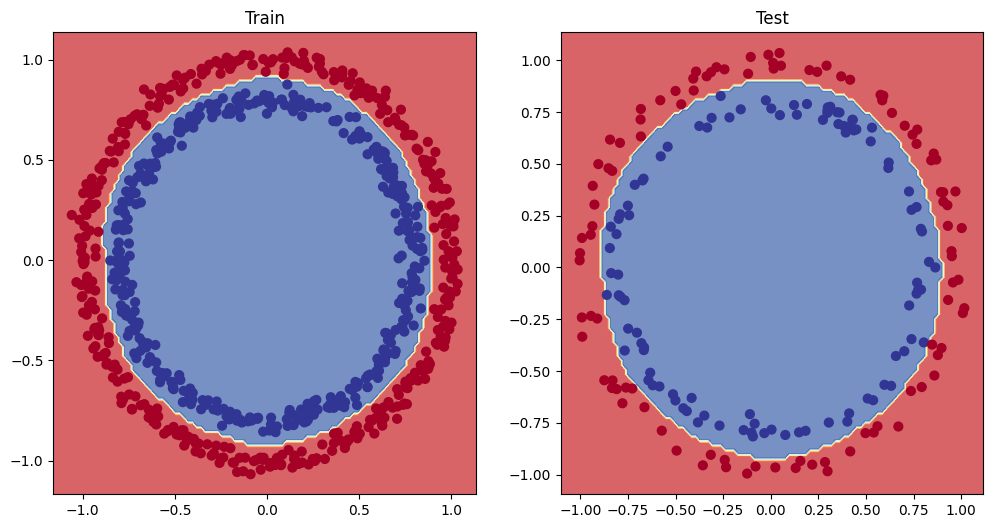

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2 , 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### Multi-class classification

In [36]:
import torch
a=torch.arange(-10, 10)
a

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

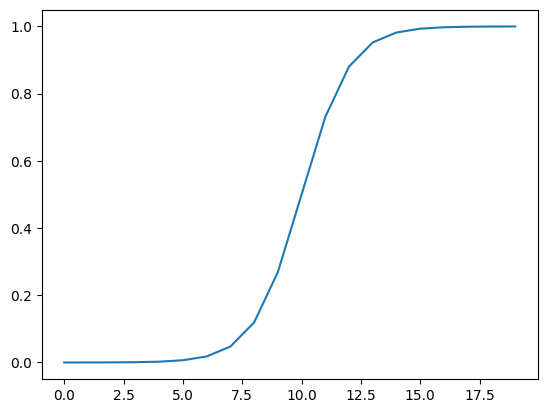

In [37]:
import matplotlib.pyplot as plt
from torch import nn
plt.plot(torch.sigmoid(a))

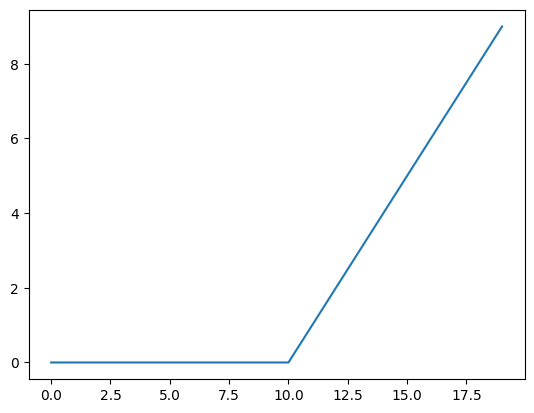

In [38]:
plt.plot(torch.relu(a))

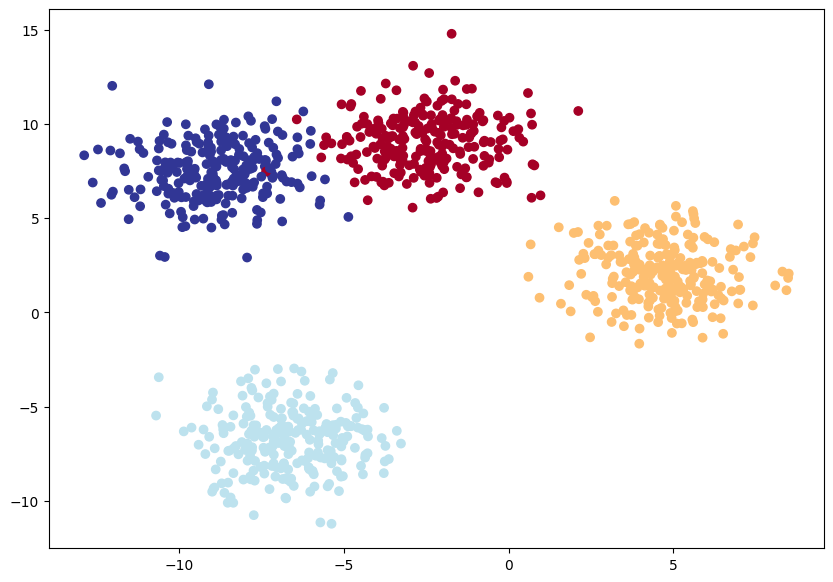

In [39]:
#import dependencies
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42

X_blob, y_blob=make_blobs(
          n_samples=1000,
          n_features=NUM_FEATURES,
          centers=NUM_CLASSES,
          cluster_std=1.5,
          random_state=RANDOM_SEED
)

# Convert X_blob to FloatTensor and y_blob to LongTensor for classification labels
X_blob=torch.from_numpy(X_blob).type(torch.FloatTensor)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test=train_test_split(
                                          X_blob,
                                          y_blob,
                                          test_size=0.2,
                                          random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [40]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [41]:
class BlobModuleV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4=BlobModuleV0(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModuleV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [42]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_4.parameters(), lr=.01)


In [43]:
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test.to(device).float())
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])

In [44]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [45]:
y_pred_probs=torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [46]:
y_preds=torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [47]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [48]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
epochs=1000
# Ensure X_blob_train and X_blob_test are float tensors for the model
X_blob_train, y_blob_train, X_blob_test, y_blob_test = X_blob_train.to(device).float(), y_blob_train.to(device), X_blob_test.to(device).float(), y_blob_test.to(device)
for epoch in range(epochs):
  model_4.train()
  y_logits=model_4(X_blob_train)
  y_pred=torch.softmax(y_logits, dim=1).argmax(dim=1)
  # Calculate loss using raw logits, not predicted labels
  loss=loss_fn(y_logits, y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,
                  y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    x_logits=model_4(X_blob_test)
    x_pred=torch.softmax(x_logits, dim=1).argmax(dim=1)
    x_loss=loss_fn(x_logits, y_blob_test)
    x_acc=accuracy_fn(y_true=y_blob_test,
                      y_pred=x_pred)
  if epoch%10==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} Acc : {acc:.2f} | Test Loss: {x_loss:.5f} | Test Acc: {x_acc:.2f}')

Epoch: 0 | Loss: 1.15883 Acc : 40.38 | Test Loss: 1.09778 | Test Acc: 46.50
Epoch: 10 | Loss: 0.66860 Acc : 80.88 | Test Loss: 0.68123 | Test Acc: 93.00
Epoch: 20 | Loss: 0.38183 Acc : 98.00 | Test Loss: 0.36981 | Test Acc: 99.00
Epoch: 30 | Loss: 0.12265 Acc : 98.88 | Test Loss: 0.10953 | Test Acc: 99.50
Epoch: 40 | Loss: 0.04622 Acc : 99.25 | Test Loss: 0.03843 | Test Acc: 99.50
Epoch: 50 | Loss: 0.03069 Acc : 99.25 | Test Loss: 0.02161 | Test Acc: 99.50
Epoch: 60 | Loss: 0.02691 Acc : 99.25 | Test Loss: 0.01760 | Test Acc: 99.50
Epoch: 70 | Loss: 0.02535 Acc : 99.25 | Test Loss: 0.01534 | Test Acc: 99.50
Epoch: 80 | Loss: 0.02456 Acc : 99.12 | Test Loss: 0.01451 | Test Acc: 99.50
Epoch: 90 | Loss: 0.02404 Acc : 99.38 | Test Loss: 0.01350 | Test Acc: 99.50
Epoch: 100 | Loss: 0.02365 Acc : 99.38 | Test Loss: 0.01305 | Test Acc: 99.50
Epoch: 110 | Loss: 0.02332 Acc : 99.38 | Test Loss: 0.01257 | Test Acc: 99.50
Epoch: 120 | Loss: 0.02304 Acc : 99.38 | Test Loss: 0.01216 | Test Acc: 99.

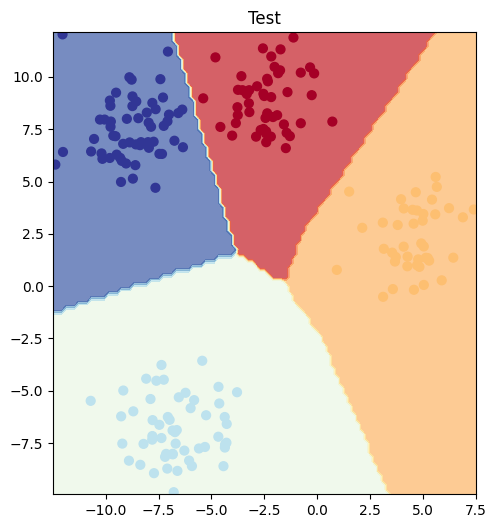

In [49]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [50]:
!pip install torchmetrics

In [51]:
from torchmetrics import Accuracy
t_m=Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)
t_m(x_pred, y_blob_test)

tensor(1.)

### Assignment

In [52]:
import torch
device ='cuda' if torch.cuda.is_available() else 'cpu'

RANDOM_SEED=42

In [53]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
samples=make_moons(n_samples=1000, noise=0.05, random_state=RANDOM_SEED)
X_moon, y_moon=samples
X_moon=torch.from_numpy(X_moon).type(torch.FloatTensor)
y_moon=torch.from_numpy(y_moon).type(torch.LongTensor)

X_moon_train, X_moon_test, y_moon_train, y_moon_test=train_test_split(X_moon, y_moon,
                                                                      test_size=0.2,
                                                                      random_state=RANDOM_SEED)
len(X_moon_train), len(X_moon_test), len(y_moon_train), len(y_moon_test)


(800, 200, 800, 200)

In [54]:
import pandas as pd
moon=pd.DataFrame({'X1': X[:, 0],
                  'X2': X[:, 1],
                  'labels': y})
moon.head(10)

,X1,X2,labels
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0
5,-0.479646,0.676435,1.0
6,-0.013648,0.803349,1.0
7,0.771513,0.147760,1.0
8,-0.169322,-0.793456,1.0
9,-0.121486,1.021509,0.0


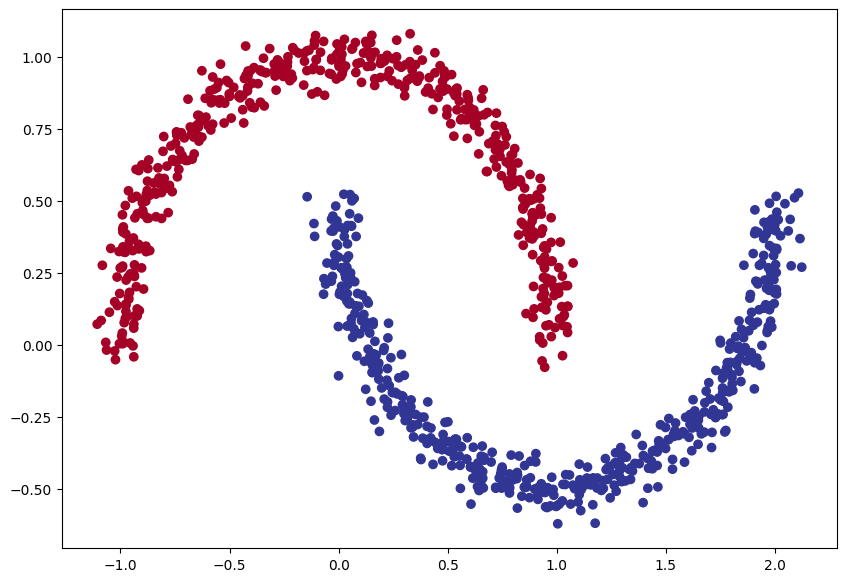

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap=plt.cm.RdYlBu)
#

In [56]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
      super().__init__()
      self.linear_layer_moon=nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_moon(x)

# Instantiate the model
## Your code here ##
model_assignment=MoonModelV0(input_features=2, output_features=1, hidden_units=8).to(device)
model_assignment

MoonModelV0(
  (linear_layer_moon): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [57]:
# Setup loss function
from torch import nn
loss_fn=nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer=torch.optim.Adam(params=model_assignment.parameters(), lr=0.01)


In [58]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
model_assignment.eval()
with torch.inference_mode():
  y_logits=model_assignment(X_moon_test.to(device).float())
print(y_logits[:5])

# Prediction probabilities
print("Pred probs:")
## Your code here ##
y_preds=torch.sigmoid(y_logits)
print(y_preds[:5])

# Prediction labels
print("Pred labels:")
## Your code here ##
y_pred_labels=torch.round(y_preds)
print(y_pred_labels[:5])

Logits:
tensor([[-0.0975],
        [-0.2098],
        [-0.1890],
        [-0.1876],
        [-0.3129]])
Pred probs:
tensor([[0.4757],
        [0.4477],
        [0.4529],
        [0.4532],
        [0.4224]])
Pred labels:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [59]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="binary", num_classes=2).to(device) # send accuracy function to device
acc_fn

BinaryAccuracy()

In [60]:
## TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
#Setup epochs
epochs=1000

#Send data to the device
# y_train and y_moon_test need to be float for BCEWithLogitsLoss
X_moon_test, y_moon_test, X_moon_train, y_moon_train = X_moon_test.to(device), y_moon_test.to(device).float().reshape(-1, 1), X_moon_train.to(device), y_moon_train.to(device).float().reshape(-1, 1)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_assignment.train()
  # 1. Forward pass (logits output)
  y_logits=model_assignment(X_moon_train)
  # Turn logits into prediction probabilities
  y_pred_probs=torch.sigmoid(y_logits)


  # Turn prediction probabilities into prediction labels
  # Squeeze to ensure y_pred_labels is (batch_size,) if y_logits is (batch_size, 1)
  y_pred_labels=torch.round(y_pred_probs).squeeze()


  # 2. Calculaute the loss
  # loss = compare model raw outputs to desired model outputs
  # y_logits is (batch_size, 1) and y_moon_train is (batch_size,1)
  loss = loss_fn(y_logits, y_moon_train)

  # Calculate the accuracy
  # The accuracy function needs to compare pred labels (not logits) with actual labels
  # y_pred_labels is (batch_size,) and y_moon_train.int() is (batch_size,)
  acc = acc_fn(y_pred_labels, y_moon_train.int().squeeze())

  # 3. Zero the gradients
  optimizer.zero_grad()


  # 4. Loss backward (perform backpropagation)
  loss.backward()
  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_assignment.eval() # Corrected: use model_assignment
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits=model_assignment(X_moon_test) # Corrected: use X_moon_test for testing

    # Turn the test logits into prediction labels
    test_pred_probs=torch.sigmoid(test_logits)
    test_pred_labels=torch.round(test_pred_probs).squeeze() # Squeeze for acc_fn
    # 2. Caculate the test loss/acc
    test_loss=loss_fn(test_logits, y_moon_test)
    test_acc=acc_fn(test_pred_labels, y_moon_test.int().squeeze()) # Use test_pred_labels and y_moon_test.int()


  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f'Epoch: {epoch}| Loss: {loss:.5f}| Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}')

Epoch: 0| Loss: 0.71199| Acc: 0.50 | Test Loss: 0.69885 | Test acc: 0.50
Epoch: 100| Loss: 0.19580| Acc: 0.91 | Test Loss: 0.18594 | Test acc: 0.93
Epoch: 200| Loss: 0.01381| Acc: 1.00 | Test Loss: 0.01056 | Test acc: 1.00
Epoch: 300| Loss: 0.00430| Acc: 1.00 | Test Loss: 0.00301 | Test acc: 1.00
Epoch: 400| Loss: 0.00229| Acc: 1.00 | Test Loss: 0.00143 | Test acc: 1.00
Epoch: 500| Loss: 0.00146| Acc: 1.00 | Test Loss: 0.00085 | Test acc: 1.00
Epoch: 600| Loss: 0.00103| Acc: 1.00 | Test Loss: 0.00056 | Test acc: 1.00
Epoch: 700| Loss: 0.00077| Acc: 1.00 | Test Loss: 0.00041 | Test acc: 1.00
Epoch: 800| Loss: 0.00059| Acc: 1.00 | Test Loss: 0.00030 | Test acc: 1.00
Epoch: 900| Loss: 0.00048| Acc: 1.00 | Test Loss: 0.00023 | Test acc: 1.00


In [61]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

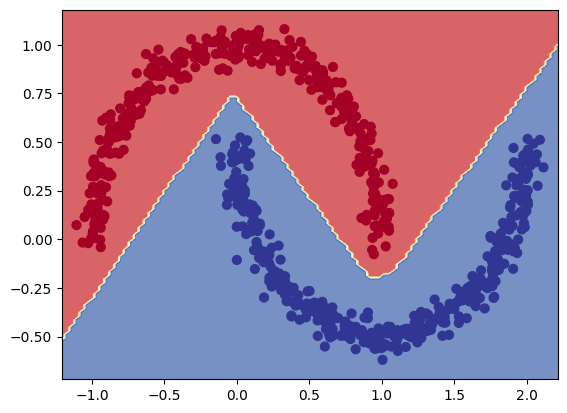

In [62]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_assignment, X_moon_train, y_moon_train)


In [63]:
a=torch.arange(-10, 10)
a

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

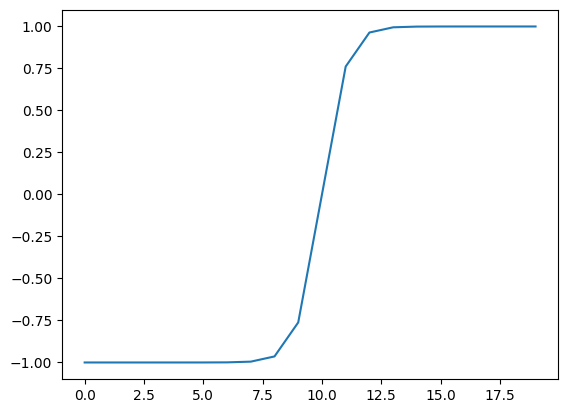

In [64]:
plt.plot(torch.tanh(a))

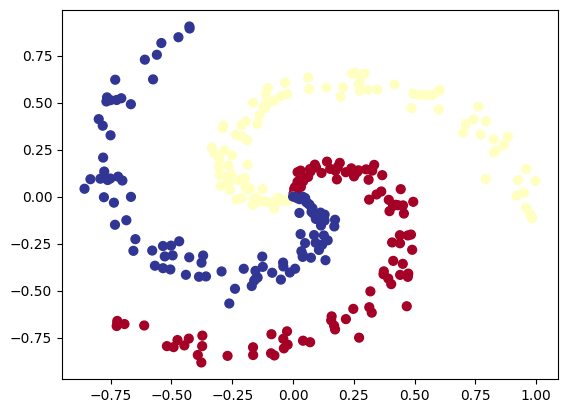

In [85]:
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [86]:

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [87]:

# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [88]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [89]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2160, -0.0600,  0.2256],
        [-0.2020, -0.0530,  0.2257],
        [-0.2223, -0.0604,  0.2384],
        [-0.2174, -0.0555,  0.2826],
        [-0.2201, -0.0502,  0.2792],
        [-0.2195, -0.0565,  0.2457],
        [-0.2212, -0.0581,  0.2440],
        [-0.2251, -0.0631,  0.2354],
        [-0.2116, -0.0548,  0.2336],
        [-0.2170, -0.0552,  0.2842]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2685, 0.3139, 0.4176],
        [0.2707, 0.3142, 0.4151],
        [0.2659, 0.3126, 0.4215],
        [0.2615, 0.3074, 0.4311],
        [0.2609, 0.3092, 0.4299],
        [0.2653, 0.3123, 0.4224],
        [0.2653, 0.3123, 0.4224],
        [0.2659, 0.3127, 0.4214],
        [0.2681, 0.3136, 0.4184],
        [0.2614, 0.3072, 0.4314]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [93]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.01)


In [94]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")



Epoch: 0 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 100 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 200 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 300 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 400 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 500 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 600 | Loss: 0.01 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 700 | Loss: 0.01 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.01 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.01 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


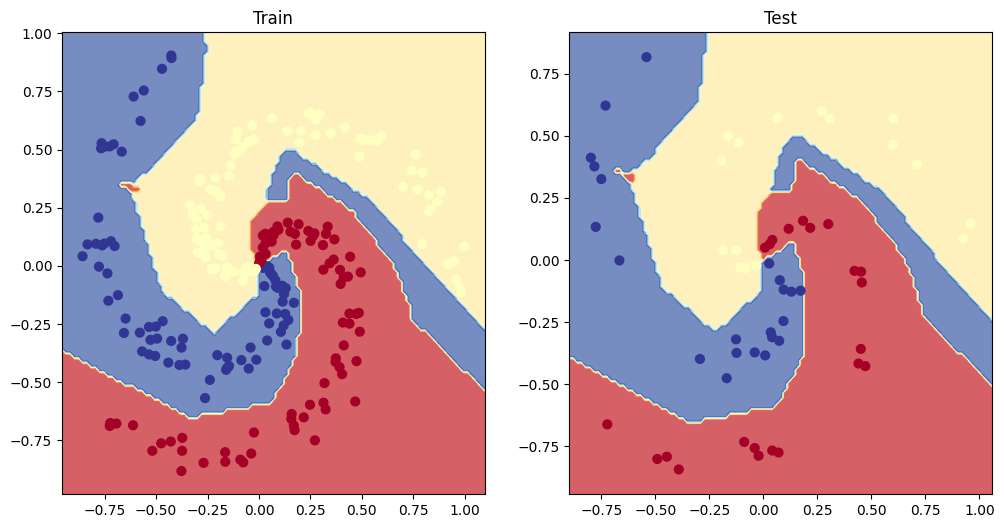

In [95]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)